In [34]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import pandas as pd
import numpy as np
import swifter
import seaborn as sns
import matplotlib.pyplot

pd.set_option('max.rows', None)
pd.set_option('max.columns', None)

import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score, f1_score

import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

In [35]:
%store -r train_data_formodel
%store -r test_data
%store -r my_data
%store -r uniques

In [36]:
train_data = train_data_formodel[train_data_formodel.columns.values[9:,]]

In [37]:
train_data.columns.values

array(['Li7', 'Be9', 'B11', 'Mg24', 'Al27', 'Si28', 'P31', 'S33', 'K39',
       'Ca42', 'Sc45', 'Ti47', 'V51', 'Cr52', 'Mn55', 'Fe56', 'Co59',
       'Ni60', 'Cu63', 'Zn68', 'Ga69', 'Ge72', 'As75', 'Rb85', 'Sr88',
       'Y89', 'Zr90', 'Nb93', 'Mo95', 'Cd111', 'In115', 'Sn118', 'Cs133',
       'Ba137', 'La139', 'Ce140', 'Pr141', 'Nd146', 'Sm147', 'Eu153',
       'Gd157', 'Tb159', 'Dy163', 'Ho165', 'Er166', 'Tm169', 'Yb172',
       'Lu175', 'Hf178', 'Ta181', 'Pb208', 'Th232', 'U238', 'class'],
      dtype=object)

In [38]:
y_train = np.array(train_data['class'])
train_data_feats = train_data.drop(['class'], axis = 1)

In [39]:
x_train = np.array(train_data_feats)
x_test = np.array(test_data[test_data.columns.values[9:-1]])

In [40]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(1243, 53)
(363, 53)
(1243,)


In [41]:
# Some useful parameters which will come in handy later on
ntrain = x_train.shape[0]
ntest = x_test.shape[0]
SEED = 42 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None, set_seed = True):

        if set_seed:
            params['random_state'] = seed

            
        self.clf = clf(**params)
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

In [42]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [43]:

rf_params = {
    'n_jobs': -1,
    'n_estimators': 2000, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 1
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':2000,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 1
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 2000,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 2000,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 1
}

svc_params = {
    'C' : 0.025
    }
# Support Vector Classifier parameters 


knn_params = {
    'n_jobs' : -1
}

bgg_params = {
    'n_jobs' : -1,
    'n_estimators':2000
}

In [46]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)
knn = SklearnHelper(clf=KNeighborsClassifier, params=knn_params, set_seed = False)
bgg = SklearnHelper(clf=BaggingClassifier, seed=SEED, params=bgg_params)


In [47]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
print('starting random forest')
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
print('starting adaboost')
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
print('starting gradient boost')
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
print('starting support vector machine')
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier
print('starting knn')
knn_oof_train, knn_oof_test = get_oof(knn,x_train, y_train, x_test)
print('starting bagging')
bgg_oof_train, bgg_oof_test = get_oof(bgg,x_train, y_train, x_test)
print("Training is complete")

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:

starting random forest


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:

starting adaboost
starting gradient boost
      Iter       Train Loss   Remaining Time 
         1        1755.8990            6.42m
         2        1410.0986            6.70m
         3        1172.6790            6.79m
         4         985.2995            6.82m
         5         842.2294            6.83m
         6         718.4228            6.84m
         7         617.2412            6.87m
         8         529.8198            6.90m
         9         457.3486            6.91m
        10         394.8410            6.92m
        20         107.2611            6.99m
        30          37.6446            6.96m
        40          17.6137            6.88m
        50          11.5389            6.57m
        60           9.7668            6.00m
        70           9.0807            5.45m
        80           8.8609            4.93m
        90           8.7844            4.48m
       100           8.7305            4.12m
       200           8.5471            2.39m
       300  

In [49]:
base_predictions_train = pd.DataFrame( 
    {'RandomForest': rf_oof_train.ravel(),
    'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel(),
    'supportvector': svc_oof_train.ravel(),
    'knn': knn_oof_train.ravel(),
    'bgg': bgg_oof_train.ravel()
})
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost,supportvector,knn,bgg
0,19.0,19.0,22.0,19.0,19.0,8.0,8.0
1,19.0,19.0,22.0,19.0,19.0,8.0,8.0
2,19.0,19.0,22.0,19.0,19.0,5.0,5.0
3,10.0,20.0,10.0,10.0,19.0,17.0,10.0
4,19.0,19.0,5.0,19.0,19.0,5.0,19.0


In [50]:
base_predictions_train.shape

(1243, 7)

In [51]:
base_predictions_test = pd.DataFrame( 
    {'RandomForest': rf_oof_test.ravel(),
     'ExtraTrees': et_oof_test.ravel(),
     'AdaBoost': ada_oof_test.ravel(),
      'GradientBoost': gb_oof_test.ravel(),
    'supportvector': svc_oof_test.ravel(),
    'knn': knn_oof_test.ravel(),
     'bgg': bgg_oof_test.ravel()                                  
    })
base_predictions_test.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost,supportvector,knn,bgg
0,18.4,16.6,16.0,16.8,13.0,20.6,18.4
1,18.4,16.6,16.6,16.8,13.0,20.6,18.4
2,18.4,16.6,14.8,18.2,13.0,20.6,18.4
3,19.2,19.0,9.2,19.8,13.0,20.2,19.2
4,20.2,19.0,13.2,20.2,13.0,18.8,20.8


In [52]:
X_2_train = np.array(base_predictions_train)
y_2_train = np.array(y_train)



In [53]:
base_predictions_train.astype(float).corr().values 

array([[ 1.00000000e+00,  6.06063124e-01,  2.31409887e-01,
         4.25425486e-01,  6.90946891e-04,  3.02990858e-01,
         4.38899447e-01],
       [ 6.06063124e-01,  1.00000000e+00,  1.72618868e-01,
         3.13361567e-01,  8.17489276e-02,  1.65648214e-01,
         3.05971952e-01],
       [ 2.31409887e-01,  1.72618868e-01,  1.00000000e+00,
         1.64545704e-01, -1.06731198e-02,  1.05669529e-01,
         2.29319550e-01],
       [ 4.25425486e-01,  3.13361567e-01,  1.64545704e-01,
         1.00000000e+00, -1.02574543e-01,  2.17043677e-01,
         4.98841491e-01],
       [ 6.90946891e-04,  8.17489276e-02, -1.06731198e-02,
        -1.02574543e-01,  1.00000000e+00, -1.93070102e-01,
        -9.37808430e-02],
       [ 3.02990858e-01,  1.65648214e-01,  1.05669529e-01,
         2.17043677e-01, -1.93070102e-01,  1.00000000e+00,
         1.95014569e-01],
       [ 4.38899447e-01,  3.05971952e-01,  2.29319550e-01,
         4.98841491e-01, -9.37808430e-02,  1.95014569e-01,
         1.0000000

In [54]:
trace = go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Rainbow',
            showscale=True,
            reversescale = True
)


data = [trace]
fig = dict(data=data)

py.plot(fig, output_type='file', filename='corrheatmap'+ '.html')

'file:///home/robert/developer/archeo/corrheatmap.html'

In [55]:
corr_df = pd.DataFrame(data = base_predictions_train.astype(float).corr().values, columns = base_predictions_train.columns.values)
corr_df_abs = corr_df.abs()

In [56]:
summations = []
for col in corr_df_abs.columns.values:
    summations.append(corr_df_abs[col].sum())


In [57]:
model_correlation_summations = pd.DataFrame(data = summations, index=list(corr_df_abs.columns.values))
model_correlation_summations

,0
RandomForest,3.005480
ExtraTrees,2.645413
AdaBoost,1.914237
GradientBoost,2.721792
supportvector,1.482538
knn,2.179437
bgg,2.761828


In [58]:
xg = xgb.XGBClassifier(max_depth = 20, n_estimators = 2000, n_jobs=-1)
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X_2_train, y_2_train)
class_f1_scores = []
macro_f1_scores = []
accuracy_scores = []
feat_imp =[]
f1_dict = {}
count = 0
for train_index, test_index in skf.split(X_2_train, y_2_train):
    count = count + 1
    print('making model:')
    key = 'round' + str(count)
    print(count)
    X_train_loc, X_test_loc = X_2_train[train_index], X_2_train[test_index]
    y_train_loc, y_test_loc = y_2_train[train_index], y_2_train[test_index]
    xg.fit(X_train_loc, y_train_loc)
    y_pred = xg.predict(X_test_loc)
    class_f1_scores = f1_score(y_test_loc, y_pred, average = None)
    accuracy = accuracy_score(y_test_loc, y_pred)
    accuracy_scores.append(accuracy)
    macro_f1_scores.append(f1_score(y_test_loc, y_pred, average = 'weighted'))
    f1_dict[key] = class_f1_scores 
    

making model:
1
making model:
2
making model:
3
making model:
4
making model:
5
making model:
6
making model:
7
making model:
8
making model:
9
making model:
10


In [59]:
f1_df = pd.DataFrame(data = f1_dict)


In [60]:
for key in f1_dict:
    print(len(f1_dict[key]))

23
23
23
23
23
23
23
23
23
23


### Below are the encodings for the class variable

In [61]:
print(train_data['class'].unique())
print(list(uniques))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
['FH', 'ER', 'WW', 'TC', 'BC_CS', 'KQ', 'AR', 'SL', 'FG', 'WB_BX', 'PF', 'BM', 'WH', 'SQ_BP', 'WN', 'BH', 'PH', 'LB', 'PC', 'SV_SE', 'BA', 'WA', 'MM']


In [62]:
f1_df_final = pd.concat([f1_df, pd.Series(uniques)], axis = 1)

In [63]:
f1_df_final.rename(columns={0:'class'}, inplace=True)
f1_df_final.set_index('class', drop = True, inplace = True)

### Boxplot showing the distribution of class f1 scores from 10 models

Text(0.5,0,"Bedrock site or superficial deposit 'region'")

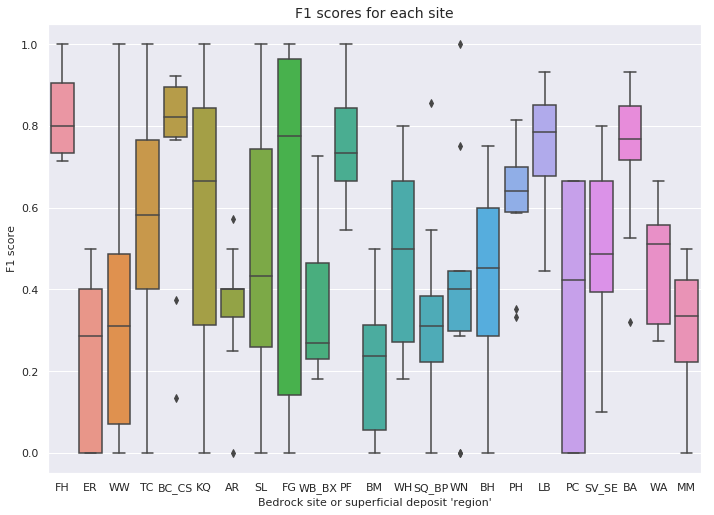

In [64]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = sns.boxplot(data = f1_df_final.T)
plot.set_title('F1 scores for each site', fontdict={'fontsize': 14})
plot.set_ylabel('F1 score', fontdict={'fontsize': 11})
plot.set_xlabel("Bedrock site or superficial deposit 'region'", fontdict={'fontsize': 11})

#f save_plots == True:
#    fig = plot.get_figure()
#    fig.savefig('site_specific_f1_scores.png')

### Boxplot showing the macro F1 score with weighted averages

Text(0.5,0,'F1-score')

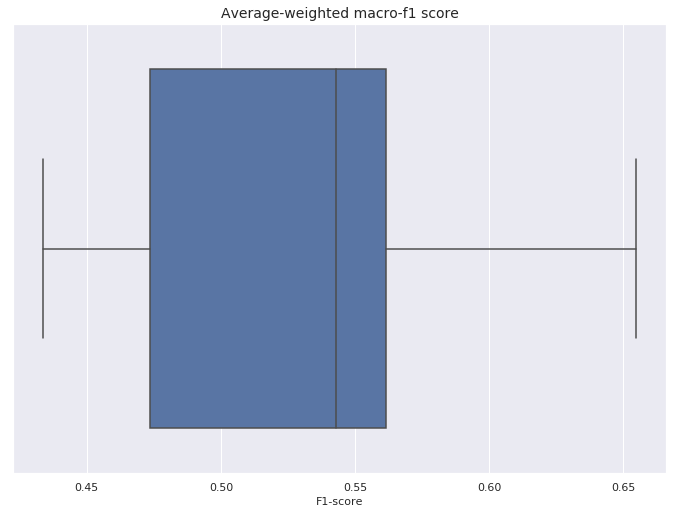

In [65]:
plot = sns.boxplot(macro_f1_scores)
plot.set_title('Average-weighted macro-f1 score', fontdict={'fontsize': 14})
plot.set_xlabel("F1-score", fontdict={'fontsize': 11})

#if save_plots == True:
#    fig = plot.get_figure()
#    fig.savefig('macro_f1_scores.png')

### Boxplot showing accuracy scores

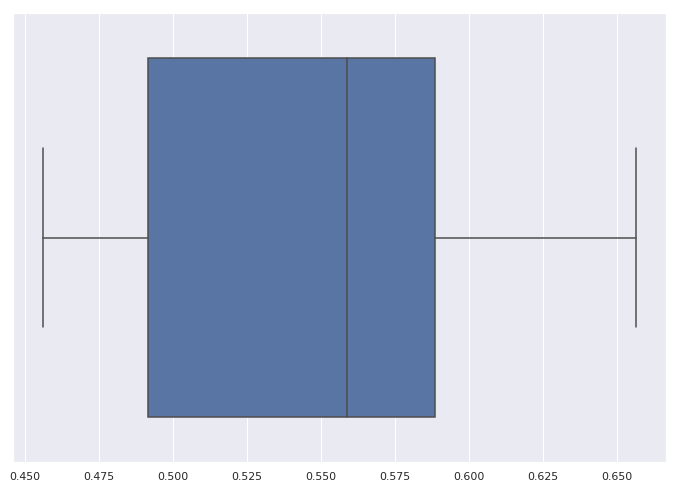

In [66]:
sns.boxplot(accuracy_scores)